In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
TESTING = True

In [73]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [53]:
from nsb_aad.frame_based_detectors.mario_detector import MarioDetector
from phaunos_ml.utils import feature_utils, annotation_utils, dataset_utils, tf_utils

In [6]:
SR = 22050

# Build dataset

The model will be trained on:
- 10 classes from xeno-canto
- various classes from Audioset which are possibly observable in the field (e.g. plane, wind, speech...)

Data from Audioset will be used both as training data and as mixup augmentation data.

Because we will use several datasets, we must modify the label id (basically indices in the list of labels) in the annotations to avoid conflicts. Our dataset from xeno-canto (all recordings from France) has 505 classes, and Audioset has 527 classes, so we add 1000 to the label ids in Audioset solves the problem.

In [7]:
DATASET_ROOT = '/home/jul/data/'
AUDIO_DIRNAME = 'audio/wav_22050hz_MLR'
ANNOTATION_DIRNAME = 'annotations_ingerop'
OUTPUT_DIR = os.path.join(DATASET_ROOT, 'ingerop')

## Setup Audioset dataset

In [8]:
AUDIOSET_RELPATH = 'audioset' # relative to DATASET_ROOT
AUDIOSET_ANNOTATION_ORIGINAL_DIRNAME = 'annotations'
AUDIOSET_LABEL_OFFSET = 1000

In [9]:
# Add 1000 to audioset annotation label ids
for path, _, filenames in os.walk(os.path.join(DATASET_ROOT, AUDIOSET_RELPATH, AUDIOSET_ANNOTATION_ORIGINAL_DIRNAME)):
    for filename in filenames:
        ann_filename = os.path.join(path, filename)
        ann_set = annotation_utils.read_annotation_file(ann_filename)
        new_ann_set = set([annotation_utils.Annotation(            
            ann.start_time,
            ann.end_time,
            frozenset([i+AUDIOSET_LABEL_OFFSET for i in ann.label_set])
        ) for ann in ann_set])
        annotation_utils.write_annotation_file(
            new_ann_set,
            ann_filename.replace(AUDIOSET_ANNOTATION_ORIGINAL_DIRNAME, ANNOTATION_DIRNAME)
        )

In [10]:
# Select classes that can be realistically observable in the field (here ids are audioset original ids)
selected_audioset_classes = [(0,"Speech"),(8,"Shout"),(14,"Screaming"),(16,"Laughter"),(28,"Choir"),(38,"Groan"),
                             (43,"Snoring"),(53,"Walk, footsteps"),(122,"Canidae, dogs, wolves"),
                             (123,"Rodents, rats, mice"),(132,"Frog"),(137,"Music"),(283,"Wind"),
                             (284,"Rustling leaves"),(286,"Thunderstorm"),(287,"Thunder"),(288,"Water"),
                             (289,"Rain"),(290,"Raindrop"),(299,"Crackle"),(300,"Vehicle"),(301,"Boat, Water vehicle"),
                             (304,"Motorboat, speedboat"),(305,"Ship"),(306,"Motor vehicle (road)"),(307,"Car"),
                             (308,"Vehicle horn, car horn, honking"),(310,"Car alarm"),(312,"Skidding"),
                             (313,"Tire squeal"),(314,"Car passing by"),(316,"Truck"),(317,"Air brake"),
                             (318,"Air horn, truck horn"),(319,"Reversing beeps"),(320,"Ice cream truck, ice cream van"),
                             (321,"Bus"),(322,"Emergency vehicle"),(323,"Police car (siren)"),(324,"Ambulance (siren)"),
                             (325,"Fire engine, fire truck (siren)"),(326,"Motorcycle"),
                             (327,"Traffic noise, roadway noise"),(328,"Rail transport"),(329,"Train"),
                             (330,"Train whistle"),(331,"Train horn"),(332,"Railroad car, train wagon"),
                             (333,"Train wheels squealing"),(334,"Subway, metro, underground"),(335,"Aircraft"),
                             (336,"Aircraft engine"),(337,"Jet engine"),(338,"Propeller, airscrew"),(339,"Helicopter"),
                             (340,"Fixed-wing aircraft, airplane"),(341,"Bicycle"),(343,"Engine"),
                             (344,"Light engine (high frequency)"),(346,"Lawn mower"),(347,"Chainsaw"),
                             (348,"Medium engine (mid frequency)"),(349,"Heavy engine (low frequency)"),
                             (350,"Engine knocking"),(351,"Engine starting"),(352,"Idling")]

In [11]:
# Get the class ids and add AUDIOSET_LABEL_OFFSET
selected_audioset_ids = [c[0]+AUDIOSET_LABEL_OFFSET for c in selected_audioset_classes]
print(selected_audioset_ids)

[1000, 1008, 1014, 1016, 1028, 1038, 1043, 1053, 1122, 1123, 1132, 1137, 1283, 1284, 1286, 1287, 1288, 1289, 1290, 1299, 1300, 1301, 1304, 1305, 1306, 1307, 1308, 1310, 1312, 1313, 1314, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1343, 1344, 1346, 1347, 1348, 1349, 1350, 1351, 1352]


In [12]:
# check audioset stats
audioset_num_files, audioset_duration = dataset_utils.dataset_stat_per_file(
    os.path.join(DATASET_ROOT, AUDIOSET_RELPATH),
    os.path.join(DATASET_ROOT, AUDIOSET_RELPATH, 'dataset.csv'),
    audio_dirname=AUDIO_DIRNAME,
    annotation_dirname=ANNOTATION_DIRNAME
)

print('Class id, total duration')
print(sorted(audioset_duration.items(), key=lambda kv: kv[1], reverse=True))

print('Class id, number of files')
print(sorted(audioset_num_files.items(), key=lambda kv: kv[1], reverse=True))

# Sort class by num files
sorted_audioset_ids = [t[0] for t in sorted(audioset_num_files.items(), key=lambda kv: kv[1], reverse=True)]

37040it [00:04, 9150.36it/s]

Class id, total duration
[(1137, 107537.70961451317), (1000, 92223.26040816383), (1300, 14146.513469387754), (1506, 12511.178095238092), (1072, 11230.426575963718), (1138, 9757.512335600908), (1027, 8745.369251700682), (1140, 6468.27628117914), (1073, 5960.94544217687), (1139, 5629.088707482995), (1307, 4929.16716553288), (1161, 4776.165170068027), (1195, 4464.594739229025), (1510, 4285.594965986396), (1509, 4261.298140589572), (1301, 4195.600589569161), (1185, 4155.114285714286), (1288, 4120.2276643990945), (1074, 3999.8370521541956), (1329, 3399.3323809523818), (1164, 3398.2089342403638), (1328, 3389.9907029478463), (1396, 3297.685170068027), (1332, 3269.9907029478463), (1098, 3124.1496598639446), (1283, 2954.323990929706), (1427, 2934.980272108845), (1437, 2916.1344217687074), (1126, 2911.3787755102057), (1111, 2910.742403628118), (1343, 2834.6273922902506), (1507, 2816.695102040817), (1476, 2690.0038548752837), (1152, 2568.2117460317463), (1285, 2515.507981859411), (1192, 2350.0117

## Setup Xeno-Canto dataset

In [13]:
XENOCANTO_RELPATH = 'xenocanto' # relative to DATASET_ROOT

In [14]:
# check xeno-canto stats
xenocanto_num_files, xenocanto_duration = dataset_utils.dataset_stat_per_file(
    os.path.join(DATASET_ROOT, XENOCANTO_RELPATH),
    os.path.join(DATASET_ROOT, XENOCANTO_RELPATH, 'dataset.csv'),
    audio_dirname=AUDIO_DIRNAME,
    annotation_dirname=ANNOTATION_DIRNAME
)

print('Class id, total duration')
print(sorted(xenocanto_duration.items(), key=lambda kv: kv[1], reverse=True))

print('Class id, number of files')
print(sorted(xenocanto_num_files.items(), key=lambda kv: kv[1], reverse=True))

# Sort class by num files
sorted_xenocanto_ids = [t[0] for t in sorted(xenocanto_num_files.items(), key=lambda kv: kv[1], reverse=True)]

19365it [00:00, 19778.71it/s]

Class id, total duration
[(182, 39859.61056689343), (200, 37169.35555555554), (445, 37165.44362811791), (486, 36600.943401360586), (487, 34273.64022675736), (268, 30815.883219954667), (324, 27382.252607709765), (348, 22488.24403628118), (17, 16500.103582766453), (483, 15142.417641723352), (347, 14666.197142857136), (355, 14512.590022675735), (174, 12920.66244897959), (152, 12652.839818594108), (332, 12555.398684807258), (440, 12128.661451247164), (227, 12067.462857142858), (446, 11145.341133786853), (447, 10952.681405895684), (346, 10931.72394557823), (345, 10547.74839002268), (50, 10002.877142857142), (448, 9989.707709750564), (267, 8985.711156462585), (429, 8914.04340136055), (269, 8888.706938775511), (159, 8615.603401360553), (3, 8517.732108843535), (452, 8226.577777777784), (409, 8010.431020408163), (27, 7661.112063492065), (13, 7565.145895691607), (296, 7400.3697052154175), (490, 7073.284671201819), (208, 6972.777369614509), (150, 6940.88634920635), (410, 6927.783628117914), (145,

In [15]:
if TESTING:
    # small dataset for fast prototyping
    selected_audioset_ids = sorted_audioset_ids[10:15]
    selected_xenocanto_ids = sorted_xenocanto_ids[11:16]
else:
    selected_audioset_ids = sorted_audioset_ids
    selected_xenocanto_ids = sorted_xenocanto_ids

# Configure activity detector

In [16]:
activity_detector_cfg = {'sample_rate': SR,
 'win_length': 512,
 'hop_length': 128,
 'min_freq': 500,
 'max_freq': 11025,
 'clipping_threshold': 3,
 'opening_kernel_shape': [2, 3],
 'median_filter_shape': 10}

In [17]:
activity_detector = MarioDetector(activity_detector_cfg)

# Configure feature (audio chunk) extractor

In [18]:
SEGMENT_DURATION = 1  # in seconds
SEGMENT_HOP_DURATION = 1  # in seconds

In [19]:
feature_extractor = feature_utils.AudioSegmentExtractor(
    sr=SR,
    example_duration=SEGMENT_DURATION,
    example_hop_duration=SEGMENT_HOP_DURATION)

# Create subset with selected classes from both datasets

In [20]:
# merge class ids
class_ids = set(selected_audioset_ids + selected_xenocanto_ids)

In [21]:
# we know that Audioset data is 10s files, so we can limit the number of Audioset files
# to match the selected xenocanto class durations (total duration per xenocanto class is about 30000s,
# so we can limit the number of audioset files per class to 3000)

#MAX_NUMBER_OF_FILES_PER_LABEL = 3000
MAX_NUMBER_OF_FILES_PER_LABEL = 1000

dataset_file = dataset_utils.create_subset(
    DATASET_ROOT,
    [AUDIOSET_RELPATH, XENOCANTO_RELPATH],
    OUTPUT_DIR,
    audio_dirname=AUDIO_DIRNAME,
    annotation_dirname=ANNOTATION_DIRNAME,
    label_set = class_ids,
    max_num_files_per_label=MAX_NUMBER_OF_FILES_PER_LABEL
)
print(dataset_file)

/home/jul/data/ingerop/subset_1572008350/subset_1572008350.csv


In [22]:
# Verify final dataset stats
num_files, duration = dataset_utils.dataset_stat_per_file(
    DATASET_ROOT,
    dataset_file,
    audio_dirname=AUDIO_DIRNAME,
    annotation_dirname=ANNOTATION_DIRNAME
)

print('Class id, total duration')
print(sorted([item for item in duration.items() if item[0] in class_ids], key=lambda kv: kv[1], reverse=True))

print('\nClass id, number of files')
print(sorted([item for item in num_files.items() if item[0] in class_ids], key=lambda kv: kv[1], reverse=True))

3280it [00:00, 7998.58it/s]

Class id, total duration
[(347, 14666.197142857136), (174, 12920.66244897959), (332, 12555.398684807258), (227, 12067.462857142858), (50, 10002.877142857142), (1307, 4929.16716553288), (1161, 4776.165170068027), (1195, 4464.594739229025), (1510, 4285.594965986396), (1509, 4261.298140589572)]

Class id, number of files
[(1307, 495), (1161, 479), (1195, 447), (1510, 429), (1509, 427), (332, 240), (174, 226), (347, 217), (227, 197), (50, 188)]


# Run activity detection and feature extraction and write to TFRecords

In [23]:
feature_dir = os.path.join(os.path.dirname(dataset_file), 'features')
dataset_utils.dataset2tfrecords(
    DATASET_ROOT,
    dataset_file,
    feature_dir,
    feature_extractor=feature_extractor,
    activity_detector=activity_detector,
    min_activity_dur=0.05,
    audio_dirname=AUDIO_DIRNAME,
    annotation_dirname=ANNOTATION_DIRNAME,
    with_labels=True
)

100%|██████████| 3281/3281 [08:15<00:00,  2.71it/s]


# Check some random TFRecords

In [26]:
tfrecords = [os.path.join(path, filename)
         for path, dirs, files in os.walk(os.path.dirname(dataset_file))
         for filename in files
         if filename.endswith(".tf")]

In [28]:
# We find twice as many files as the number of audio files because tfrecords are written in both
# a 'positive' directory (audio chunks with some audio activity detected) and a 'negative' directory
# (audio chunks with no audio activity detected). Note than both files are written, independently of
# the results of the activity detection, so some files might be empty.
len(tfrecords)

6560

In [51]:
# Pick 4 random tfrecords for each dataset (2 with activity detected, 2 with no activity detected)

selected_xenocanto_tfrecords = random.sample([tfr for tfr in tfrecords if 'positive/xenocanto' in tfr], 2) \
    + random.sample([tfr for tfr in tfrecords if 'negative/xenocanto' in tfr], 2)

print("Randomly picked up tfrecords from xeno-canto")
print(selected_xenocanto_tfrecords)

selected_audioset_tfrecords = random.sample([tfr for tfr in tfrecords if 'positive/audioset' in tfr], 2) \
    + random.sample([tfr for tfr in tfrecords if 'negative/audioset' in tfr], 2)
print("Randomly picked up tfrecords from audioset")
print(selected_audioset_tfrecords)

Randomly picked up tfrecords from xeno-canto
['/home/jul/data/ingerop/subset_1572008350/features/positive/xenocanto/audio/wav_22050hz_MLR/XC471785.R.tf', '/home/jul/data/ingerop/subset_1572008350/features/positive/xenocanto/audio/wav_22050hz_MLR/XC471992.L.tf', '/home/jul/data/ingerop/subset_1572008350/features/negative/xenocanto/audio/wav_22050hz_MLR/XC55071.R.tf', '/home/jul/data/ingerop/subset_1572008350/features/negative/xenocanto/audio/wav_22050hz_MLR/XC312590.M.tf']
Randomly picked up tfrecords from audioset
['/home/jul/data/ingerop/subset_1572008350/features/positive/audioset/audio/wav_22050hz_MLR/ifbEBJL3GRE_20000_30000.L.tf', '/home/jul/data/ingerop/subset_1572008350/features/positive/audioset/audio/wav_22050hz_MLR/tbovKStEnME_270000_280000.L.tf', '/home/jul/data/ingerop/subset_1572008350/features/negative/audioset/audio/wav_22050hz_MLR/oh08bbDVFZM_80000_90000.L.tf', '/home/jul/data/ingerop/subset_1572008350/features/negative/audioset/audio/wav_22050hz_MLR/xXFyAC2KscM_550000_5

In [97]:
# deserialize tfrecords
audioset_examples = [tf_utils.tfrecord2example(tfr, feature_extractor) for tfr in selected_audioset_tfrecords]
xenocanto_examples = [tf_utils.tfrecord2example(tfr, feature_extractor) for tfr in selected_xenocanto_tfrecords]

In [95]:
# get one random training example in each tfrecord
audioset_examples = [ex[random.randint(0, len(ex)-1)] for ex in audioset_examples if len(ex) > 0]
xenocanto_examples = [ex[random.randint(0, len(ex)-1)] for ex in xenocanto_examples if len(ex) > 0]

In [69]:
audioset_examples

[{'data': array([[-0.00100708, -0.00091553, -0.00079346, ...,  0.00448608,
           0.05435181,  0.01593018]], dtype=float32),
  'filename': b'audioset/audio/wav_22050hz_MLR/ifbEBJL3GRE_20000_30000.L.tf',
  'labels': b'1195#1212',
  'times': array([6.       , 6.9999547], dtype=float32)},
 {'data': array([[-0.32278442, -0.3855896 , -0.4724121 , ..., -0.2418518 ,
          -0.283844  , -0.2994995 ]], dtype=float32),
  'filename': b'audioset/audio/wav_22050hz_MLR/tbovKStEnME_270000_280000.L.tf',
  'labels': b'1209#1195',
  'times': array([3.       , 3.9999547], dtype=float32)},
 {'data': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'filename': b'audioset/audio/wav_22050hz_MLR/oh08bbDVFZM_80000_90000.L.tf',
  'labels': b'1435#1500#1509',
  'times': array([8.      , 8.999954], dtype=float32)}]

In [98]:
xenocanto_examples

[[{'data': array([[0.00189209, 0.01525879, 0.01257324, ..., 0.00439453, 0.00128174,
           0.00091553]], dtype=float32),
   'filename': b'xenocanto/audio/wav_22050hz_MLR/XC471785.R.tf',
   'labels': b'50',
   'times': array([0.        , 0.99995464], dtype=float32)},
  {'data': array([[ 0.00259399, -0.02972412, -0.01974487, ..., -0.00631714,
           -0.00564575,  0.0012207 ]], dtype=float32),
   'filename': b'xenocanto/audio/wav_22050hz_MLR/XC471785.R.tf',
   'labels': b'50',
   'times': array([1.       , 1.9999547], dtype=float32)},
  {'data': array([[0.00964355, 0.00338745, 0.01135254, ..., 0.00271606, 0.00149536,
           0.00646973]], dtype=float32),
   'filename': b'xenocanto/audio/wav_22050hz_MLR/XC471785.R.tf',
   'labels': b'50',
   'times': array([2.       , 2.9999547], dtype=float32)},
  {'data': array([[ 0.02081299,  0.00195312, -0.0085144 , ..., -0.04571533,
           -0.02853394,  0.00842285]], dtype=float32),
   'filename': b'xenocanto/audio/wav_22050hz_MLR/XC471

<IPython.core.display.Javascript object>


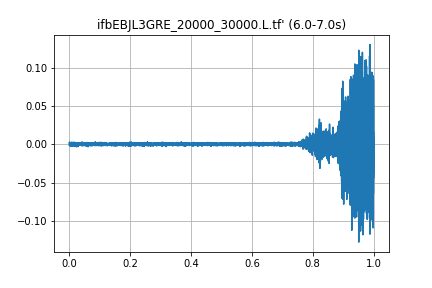

<IPython.core.display.Javascript object>


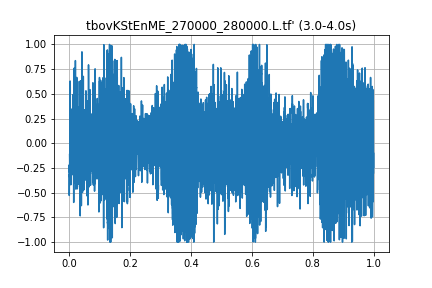

<IPython.core.display.Javascript object>


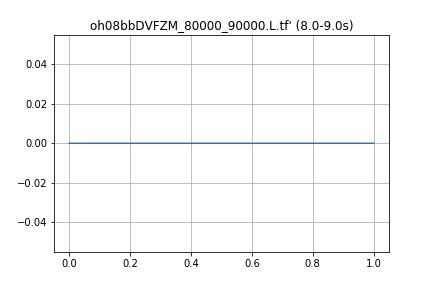

In [87]:
for ex in audioset_examples:
    plt.figure()
    plt.plot(np.arange(len(ex['data'][0]))/SR, ex['data'][0])
    plt.grid()
    plt.title(f"{os.path.basename(str(ex['filename']))} ({round(ex['times'][0])}-{round(ex['times'][1])}s)")

<IPython.core.display.Javascript object>


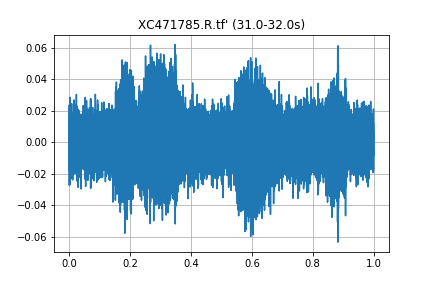

<IPython.core.display.Javascript object>


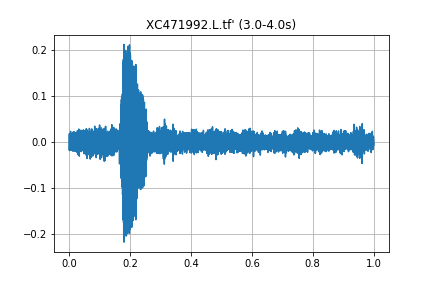

<IPython.core.display.Javascript object>


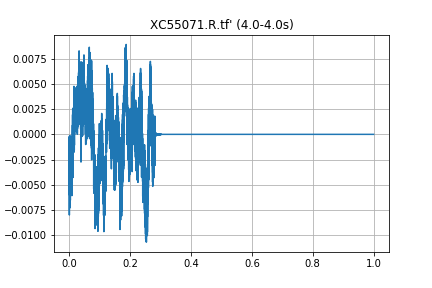

<IPython.core.display.Javascript object>


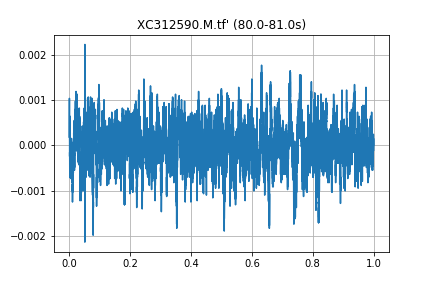

In [88]:
for ex in xenocanto_examples:
    plt.figure()
    plt.plot(np.arange(len(ex['data'][0]))/SR, ex['data'][0])
    plt.grid()
    plt.title(f"{os.path.basename(str(ex['filename']))} ({round(ex['times'][0])}-{round(ex['times'][1])}s)")

# Set up training tf.data.Dataset

Following recommendations given [here](https://www.tensorflow.org/guide/data_performance).

In [107]:
from tensorflow.python.framework import dtypes

BATCH_SIZE = 8

# get list of files as a tensor
files_training = tf.convert_to_tensor(tfrecords, dtype=dtypes.string)

# convert to tf.data.Dataset
files_training = tf.data.Dataset.from_tensor_slices(files_training)

# shuffle file list
files_training = files_training.shuffle(5000, reshuffle_each_iteration=True)

# interleave the files 
#dataset_training = files_training.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=100)

#
dataset_training = tf.data.TFRecordDataset(files_training)

# deserialize to feature (with shape (1,1,22050)) and
# one-hot encoded labels (with shape (2,), i.e. the shape of CLASS_LIST)
dataset_training = dataset_training.map(
    lambda x: tf_utils.serialized2data(x, feature_extractor.feature_shape, list(class_ids), training=True))

# shuffle
dataset_training = dataset_training.shuffle(1000)

# repeat indefinitely
dataset_training = dataset_training.repeat()

# batch
dataset_training = dataset_training.batch(BATCH_SIZE)

W1025 17:34:04.576937 140419649988416 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:143: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
